In [40]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt

from google.colab import drive

drive.mount('/content/drive')
filepath = '/content/drive/MyDrive/AOS 214 Final/pm25.csv'
filepath_ozone = '/content/drive/MyDrive/AOS 214 Final/ozone.csv'
filepath_no2 = '/content/drive/MyDrive/AOS 214 Final/no2.csv'


ca_aqi_pm25 = pd.read_csv(filepath)
ca_aqi_ozone = pd.read_csv(filepath_ozone)
ca_aqi_no2 = pd.read_csv(filepath_no2)


# drop unnecessary columns
ca_aqi_pm25 = ca_aqi_pm25.drop(['Site ID', 'POC' , 'Percent Complete' , 'Daily Obs Count', 'CBSA Code' ,
                                'CBSA Name' , 'State' ,'Method Code','State FIPS Code' ,'AQS Parameter Description'], axis=1)

ca_aqi_ozone = ca_aqi_ozone.drop(['Site ID', 'Source', 'POC' , 'Daily AQI Value' , 'Percent Complete',
                                  'Daily Obs Count', 'CBSA Code' , 'CBSA Name' , 'State' ,'Method Code','State FIPS Code' ,'AQS Parameter Description'
                                  ], axis=1)

ca_aqi_no2 = ca_aqi_no2.drop(['Site ID', 'Source', 'POC' , 'Daily AQI Value' , 'Local Site Name', 'Percent Complete', 'AQS Parameter Code',
                              'AQS Parameter Description', 'CBSA Code' , 'CBSA Name' , 'State' ,'Method Code','State FIPS Code' ,'AQS Parameter Description'
                              ], axis=1)

# merge data together
ca_aqi_pm25['Date'] = pd.to_datetime(ca_aqi_pm25['Date'])
ca_aqi_ozone['Date'] = pd.to_datetime(ca_aqi_ozone['Date'])
ca_aqi_no2['Date'] = pd.to_datetime(ca_aqi_no2['Date'])

ca_merged_temp = pd.merge(ca_aqi_pm25, ca_aqi_ozone, on=['Date', 'County'], how='outer')
ca_merged = pd.merge(ca_merged_temp, ca_aqi_no2, on=['Date', 'County'], how='outer')

#data clean
# Drop columns ending with '_x' or '_y'
ca_merged = ca_merged.loc[:, ~ca_merged.columns.str.endswith(('_x', '_y'))]
ca_merged = ca_merged.drop(columns=['Source', 'Units', 'County FIPS Code', 'Daily Obs Count',
                                    'Method Description'
                                    ])

ca_merged = ca_merged.dropna()

ca_merged = ca_merged.rename(columns={
    'Daily Mean PM2.5 Concentration': 'Daily Mean PM2.5 Concentration (ug/m3)',
    'Daily Max 8-hour Ozone Concentration': 'Daily Max 8-hour Ozone Concentration (ppm)',
    'Daily Max 1-hour NO2 Concentration': 'Daily Max 1-hour NO2 Concentration (ppb)'
})

# visualize
display(ca_merged)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,Daily Mean PM2.5 Concentration (ug/m3),Daily AQI Value,County,Daily Max 8-hour Ozone Concentration (ppm),Daily Max 1-hour NO2 Concentration (ppb),Site Latitude,Site Longitude
0,2023-01-01,3.7,21.0,Alameda,0.034,12.8,37.687526,-121.784217
1,2023-01-01,3.7,21.0,Alameda,0.034,23.6,37.743065,-122.169935
2,2023-01-01,3.7,21.0,Alameda,0.034,13.7,37.814781,-122.282347
3,2023-01-01,3.7,21.0,Alameda,0.034,15.3,37.793624,-122.263376
4,2023-01-01,3.7,21.0,Alameda,0.034,13.6,37.864767,-122.302741
...,...,...,...,...,...,...,...,...
2029507,2023-12-30,9.3,51.0,Ventura,0.039,5.0,34.252390,-119.143182
2029508,2023-12-30,2.1,12.0,Yolo,0.040,11.9,38.534450,-121.773400
2029509,2023-12-30,2.1,12.0,Yolo,0.041,11.9,38.534450,-121.773400
2029510,2023-12-30,2.3,13.0,Yolo,0.040,11.9,38.534450,-121.773400


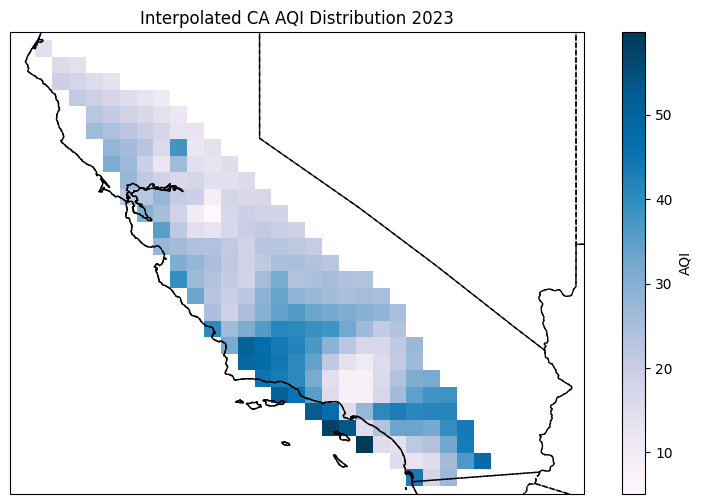

In [41]:
!pip install cartopy
from scipy.interpolate import griddata
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import griddata
import cartopy.feature as cfeature

# Step 1: Define grid parameters and resolution
degree = 0.3
lon_min, lon_max = -124.7, -113.9  # CA
lat_min, lat_max = 32.3, 41     # CA

# Step 2: Create longitude and latitude grids
nlon = int((lon_max - lon_min) / degree)
nlat = int((lat_max - lat_min) / degree)
lon_grid = np.linspace(lon_min, lon_max, nlon)
lat_grid = np.linspace(lat_min, lat_max, nlat)
lon_grid, lat_grid = np.meshgrid(lon_grid, lat_grid)


# Step 3: Function for interpolation and plotting
points = ca_merged[['Site Longitude', 'Site Latitude']].values
values = ca_merged['Daily AQI Value'].values


# Interpolate AQI data onto the grid
grid_aqi = griddata(points, values, (lon_grid, lat_grid), method='linear')

# Step 4: Create a map and plot AQI data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features like coastline and state boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='--', edgecolor='black')

# Plot the interpolated AQI data
mesh = ax.pcolormesh(lon_grid, lat_grid, grid_aqi, cmap='PuBu', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(mesh, orientation='vertical', label='AQI')
plt.title('Interpolated CA AQI Distribution 2023')
plt.show()



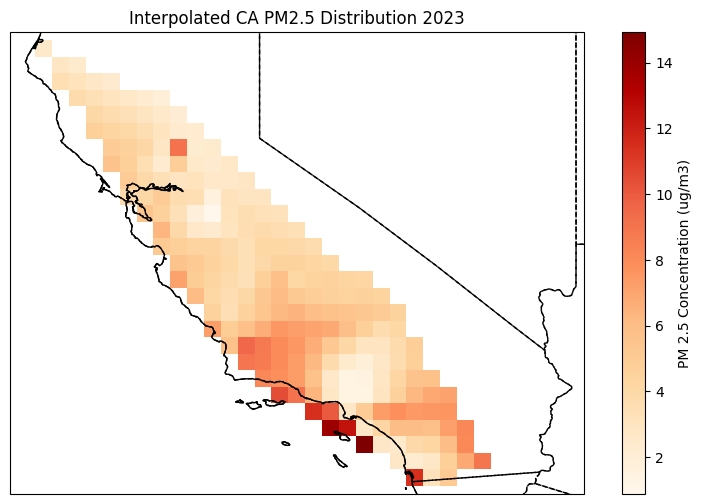

In [42]:
# Plotting a map for pm 2.5
points = ca_merged[['Site Longitude', 'Site Latitude']].values
values_pm = ca_merged['Daily Mean PM2.5 Concentration (ug/m3)'].values


# Interpolate AQI data onto the grid
grid_pm = griddata(points, values_pm, (lon_grid, lat_grid), method='linear')

# Step 4: Create a map and plot AQI data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features like coastline and state boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='--', edgecolor='black')

# Plot the interpolated AQI data
mesh = ax.pcolormesh(lon_grid, lat_grid, grid_pm, cmap='OrRd', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(mesh, orientation='vertical', label='PM 2.5 Concentration (ug/m3)')
plt.title('Interpolated CA PM2.5 Distribution 2023')
plt.show()


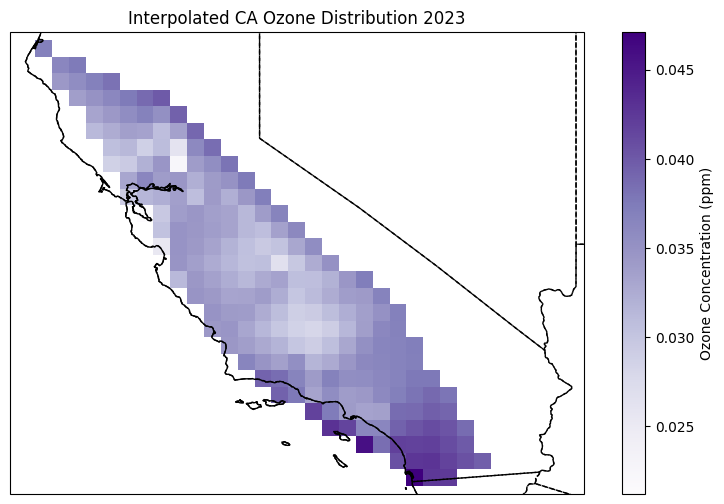

In [43]:
#plotting for ozone
points = ca_merged[['Site Longitude', 'Site Latitude']].values
values_ozone = ca_merged['Daily Max 8-hour Ozone Concentration (ppm)'].values

# Interpolate AQI data onto the grid
grid_ozone = griddata(points, values_ozone, (lon_grid, lat_grid), method='linear')

# Step 4: Create a map and plot AQI data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features like coastline and state boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='--', edgecolor='black')

# Plot the interpolated AQI data
mesh = ax.pcolormesh(lon_grid, lat_grid, grid_ozone, cmap='Purples', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(mesh, orientation='vertical', label='Ozone Concentration (ppm)')
plt.title('Interpolated CA Ozone Distribution 2023')
plt.show()


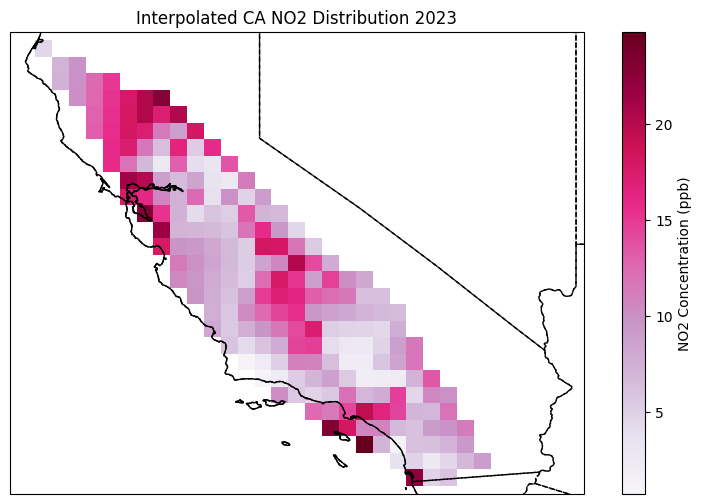

In [44]:
#plotting for NO2
points = ca_merged[['Site Longitude', 'Site Latitude']].values
values_no2 = ca_merged['Daily Max 1-hour NO2 Concentration (ppb)'].values

# Interpolate AQI data onto the grid
grid_no2 = griddata(points, values_no2, (lon_grid, lat_grid), method='linear')

# Step 4: Create a map and plot AQI data
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

# Add features like coastline and state boundaries
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.STATES, linestyle='--', edgecolor='black')

# Plot the interpolated AQI data
mesh = ax.pcolormesh(lon_grid, lat_grid, grid_no2, cmap='PuRd', transform=ccrs.PlateCarree())

# Add a colorbar
plt.colorbar(mesh, orientation='vertical', label='NO2 Concentration (ppb)')
plt.title('Interpolated CA NO2 Distribution 2023')
plt.show()


In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor


# Define features and target variable
target = 'Daily AQI Value'

# Features and target
features = ["Daily Mean PM2.5 Concentration (ug/m3)",
            "Daily Max 8-hour Ozone Concentration (ppm)",
            "Daily Max 1-hour NO2 Concentration (ppb)"]
target = "Daily AQI Value"

# Assuming 'Date' is the column with Timestamp objects
if 'Date' in ca_merged.columns:
    ca_merged['Date'] = pd.to_numeric(ca_merged['Date'])

X = ca_merged[features].values  # Feature matrix
y = ca_merged[target].values    # Target array
y = y.reshape(-1, 1)         # Reshape to match ML models' requirements


test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

print("shape of X_train:")
print("", X_train.shape)
print("shape of y_train:")
print("", y_train.shape)
print()
print("shape of X_test:")
print("", X_test.shape)
print("shape of y_test:")
print("", y_test.shape)
print()

#reshaping
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)



shape of X_train:
 (1607012, 3)
shape of y_train:
 (1607012, 1)

shape of X_test:
 (401753, 3)
shape of y_test:
 (401753, 1)



In [46]:
# 1. Linear Regression
# Train linear model

# Ensure y_train and y_test are 1D (flattened)
y_train = y_train.ravel()
y_test = y_test.ravel()

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_pred_lr = lr_model.predict(X_test)

# Calculate RMSE and R2
rmse_lr = np.sqrt(np.mean((y_test - y_pred_lr) ** 2))
r2_lr = r2_score(y_test, y_pred_lr)

print("RMSE for Linear Regression:", rmse_lr)
print(f"Linear Regression R2: {r2_lr}")

RMSE for Linear Regression: 6.671161080406327
Linear Regression R2: 0.8776206096255345


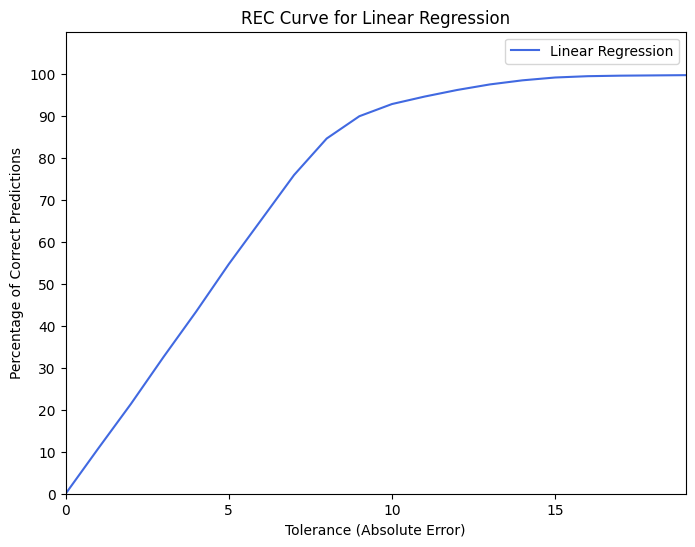

In [47]:
# Define the REC function
def rec(y_pred_lr, y_data, tol):
    """
    Calculate the percentage of predictions within a given tolerance.

    Parameters:
    - predictions: numpy array of predicted values
    - true_values: numpy array of true values
    - tol: tolerance threshold (absolute error)

    Returns:
    - Percentage of predictions within the tolerance.
    """
    # Ensure inputs are numpy arrays
    predictions = np.array(y_pred_lr).flatten()
    true_values = np.array(y_data).flatten()

    # Calculate absolute error
    errors = np.abs(predictions - true_values)

    # Count the number of predictions within the tolerance
    within_tol = np.sum(errors <= tol)

    # Calculate the percentage of correct predictions
    return 100 * (within_tol / len(true_values))

# REC curve data for linear regression
tol_max = 20 # Maximum tolerance value
rec_linear = []  # Store REC values for each tolerance level

# Calculate REC values for each tolerance level
for tol in range(tol_max):
    rec_linear.append(rec(y_pred_lr, y_test, tol))

# Plot the REC curve
plt.figure(figsize=(8, 6))
plt.plot(range(tol_max), rec_linear, label='Linear Regression', color='royalblue')
plt.title("REC Curve for Linear Regression")
plt.xlabel("Tolerance (Absolute Error)")
plt.ylabel("Percentage of Correct Predictions")
plt.ylim(0, 110)
plt.xlim(0, tol_max - 1)
plt.xticks(range(0, tol_max, 5))
plt.yticks(range(0, 110, 10))
plt.legend()
plt.show()



Random Forest MSE: 1.0929145911491693
Random Forest R2: 0.996994673538652


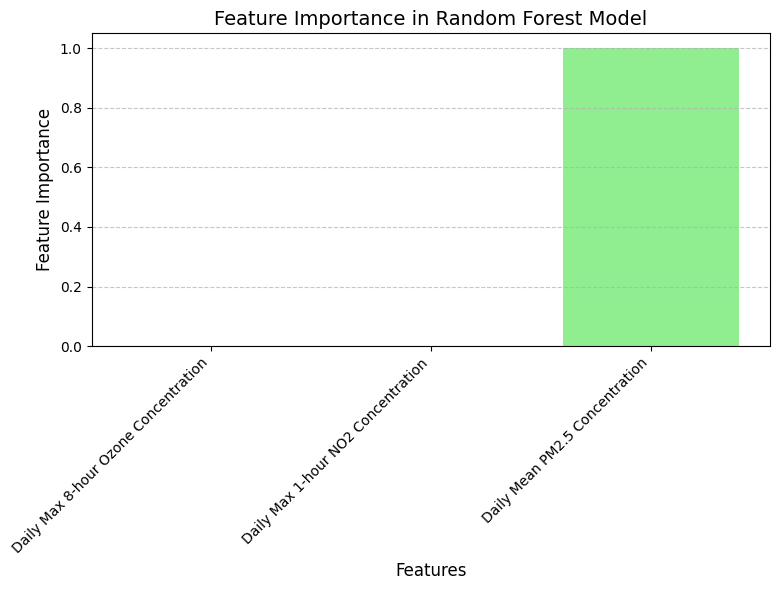

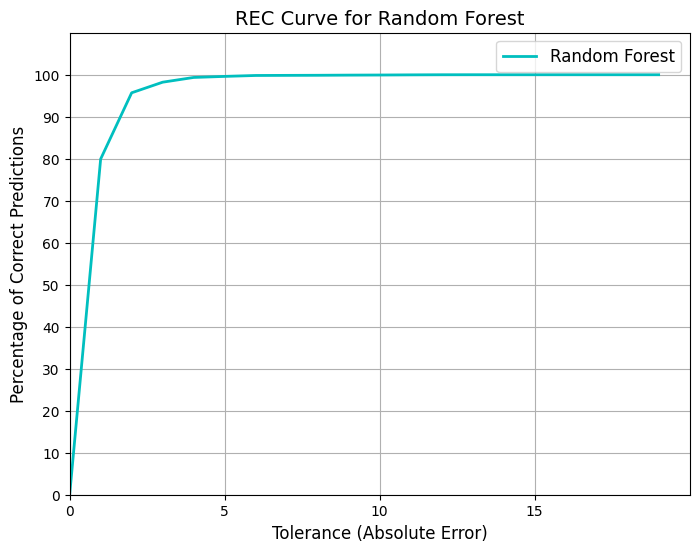

In [48]:
# 2. Random Forest Model

rf_model = RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest MSE: {mean_squared_error(y_test, y_pred_rf)}")
print(f"Random Forest R2: {r2_score(y_test, y_pred_rf)}")

rec_rf = [rec(y_pred_rf, y_test, tol) for tol in range(tol_max)]

feature_importances_rf = rf_model.feature_importances_
features = ["Daily Mean PM2.5 Concentration",
            "Daily Max 8-hour Ozone Concentration",
            "Daily Max 1-hour NO2 Concentration"]

# Sort features by importance
sorted_idx = feature_importances_rf.argsort()
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = feature_importances_rf[sorted_idx]

# Plot feature importance
plt.figure(figsize=(8, 6))
plt.bar(sorted_features, sorted_importances, color='lightgreen')
plt.ylabel("Feature Importance", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importance in Random Forest Model", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

#Plot REC
plt.figure(figsize=(8, 6))
plt.plot(range(tol_max), rec_rf, label='Random Forest', color='c', linewidth=2)
plt.title("REC Curve for Random Forest", fontsize=14)
plt.xlabel("Tolerance (Absolute Error)", fontsize=12)
plt.ylabel("Percentage of Correct Predictions", fontsize=12)
plt.grid(True)
plt.ylim(0, 110)
plt.xlim(0, tol_max)
plt.xticks(range(0, tol_max, 5))
plt.yticks(range(0, 110, 10))
plt.legend(fontsize=12)
plt.show()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 1607012, number of used features: 3
[LightGBM] [Info] Start training from score 42.450757
LightGBM MSE: 0.02995235703427825
LightGBM R2: 0.9999176361886795
Daily Mean PM2.5 Concentration: 1734
Daily Max 8-hour Ozone Concentration: 476
Daily Max 1-hour NO2 Concentration: 790


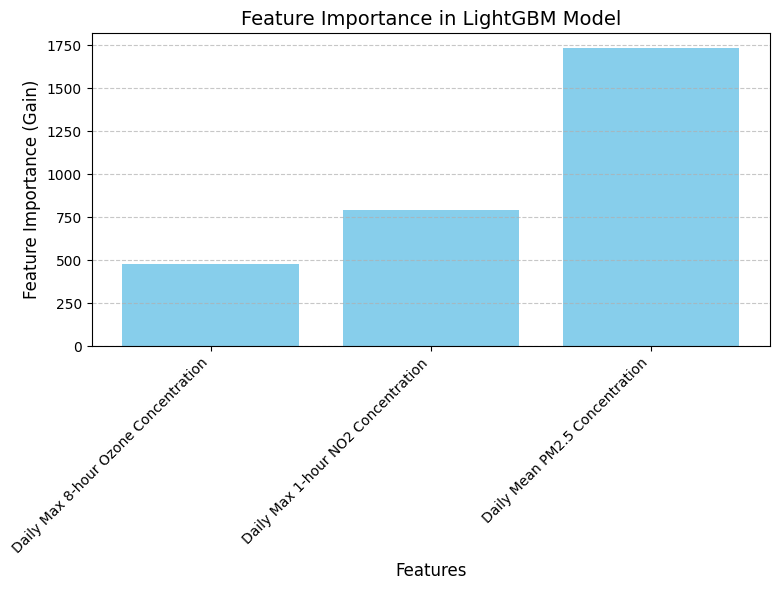

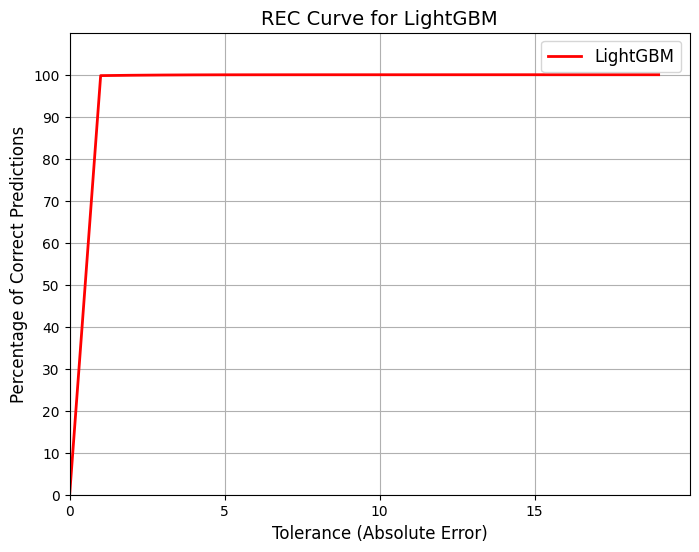

In [49]:
# 3. LightGBM
import lightgbm as lgb

gbm = lgb.LGBMRegressor()
gbm.fit(X_train, y_train)

y_pred_gbm = gbm.predict(X_test)

print(f"LightGBM MSE: {mean_squared_error(y_test, y_pred_gbm)}")
print(f"LightGBM R2: {r2_score(y_test, y_pred_gbm)}")

rec_lightgbm = [rec(y_pred_gbm, y_test, tol) for tol in range(tol_max)]

# Get feature names and their importance dynamically from the model
feature_importances = gbm.feature_importances_  # Automatically retrieve from the model
features = ["Daily Mean PM2.5 Concentration", "Daily Max 8-hour Ozone Concentration", "Daily Max 1-hour NO2 Concentration"]
for feature, importance in zip(features, feature_importances):
    print(f"{feature}: {importance}")

# Sort the features by importance
sorted_idx = feature_importances.argsort()
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = feature_importances[sorted_idx]


# Plot the feature importance as a vertical bar chart
plt.figure(figsize=(8, 6))
plt.bar(sorted_features, sorted_importances, color='skyblue')
plt.ylabel("Feature Importance (Gain)", fontsize=12)
plt.xlabel("Features", fontsize=12)
plt.title("Feature Importance in LightGBM Model", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right")  # Rotate feature labels for better readability
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(range(tol_max), rec_lightgbm, label='LightGBM', color='red', linewidth=2)
plt.title("REC Curve for LightGBM", fontsize=14)
plt.xlabel("Tolerance (Absolute Error)", fontsize=12)
plt.ylabel("Percentage of Correct Predictions", fontsize=12)
plt.grid(True)
plt.ylim(0, 110)
plt.xlim(0, tol_max)
plt.xticks(range(0, tol_max, 5))
plt.yticks(range(0, 110, 10))
plt.legend(fontsize=12)
plt.show()


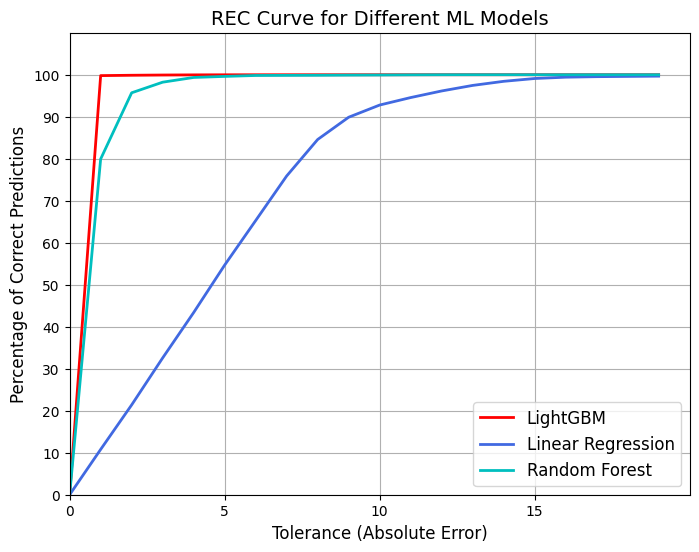

In [50]:
# Plot the REC curve
plt.figure(figsize=(8, 6))
plt.plot(range(tol_max), rec_lightgbm, label='LightGBM', color='red', linewidth=2)
plt.plot(range(tol_max), rec_linear, label='Linear Regression', color='royalblue', linewidth=2)
plt.plot(range(tol_max), rec_rf, label='Random Forest', color='c', linewidth=2)
plt.title("REC Curve for Different ML Models", fontsize=14)
plt.xlabel("Tolerance (Absolute Error)", fontsize=12)
plt.ylabel("Percentage of Correct Predictions", fontsize=12)
plt.grid(True)
plt.ylim(0, 110)
plt.xlim(0, tol_max)
plt.xticks(range(0, tol_max, 5))
plt.yticks(range(0, 110, 10))
plt.legend(fontsize=12)
plt.show()

In [51]:
# k fold cross validation
from sklearn.model_selection import cross_val_score

# use 5 fold
cv_scores = cross_val_score(gbm, X, y, scoring="neg_mean_squared_error", cv=5)

cv_rmse = np.sqrt(-cv_scores)

print(f"Cross-Validation RMSE (Mean): {np.mean(cv_rmse):.3f}")
print(f"Cross-Validation RMSE (Standard Deviation): {np.std(cv_rmse):.3f}")
print(f"Cross-Validation RMSE (Min): {np.min(cv_rmse):.3f}")
print(f"Cross-Validation RMSE (Max): {np.max(cv_rmse):.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 1607012, number of used features: 3
[LightGBM] [Info] Start training from score 44.450370


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 622
[LightGBM] [Info] Number of data points in the train set: 1607012, number of used features: 3
[LightGBM] [Info] Start training from score 43.077571


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054980 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 614
[LightGBM] [Info] Number of data points in the train set: 1607012, number of used features: 3
[LightGBM] [Info] Start training from score 41.656383


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054463 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 620
[LightGBM] [Info] Number of data points in the train set: 1607012, number of used features: 3
[LightGBM] [Info] Start training from score 41.208145


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.097915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 619
[LightGBM] [Info] Number of data points in the train set: 1607012, number of used features: 3
[LightGBM] [Info] Start training from score 41.817048
Cross-Validation RMSE (Mean): 0.384
Cross-Validation RMSE (Standard Deviation): 0.310
Cross-Validation RMSE (Min): 0.106
Cross-Validation RMSE (Max): 0.961
